In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import math
import copy
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

### Read Data

In [15]:
z_values_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/ML_data/z_values.csv')

#2000
banks_2000_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/ML_data/banks_2000.csv')
companies_2000_df = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/ML_data/companies_2000.csv')
connections_2000_df= pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/RA/ML_data/connections_2000.csv')

### Prepare Data

In [16]:
# create dict of (bank:asset)
def bank_dic_generator(banks_df):
    bank_dic = pd.Series(banks_df['Assets'].values,index = banks_df['Bank']).to_dict()
    bank_dic = dict((str(k), v) for k, v in bank_dic.items())
    return bank_dic

# create dict of (company:liability)
def company_dic_generator(companies_df):
    company_dic = pd.Series(companies_df['Liabilities'].values,index = companies_df['Company']).to_dict()
    company_dic = dict((str(k), v) for k, v in company_dic.items())
    return company_dic

# create dict of (year:z)
z_dic = pd.Series(z_values_df['z'].values,index = z_values_df['Year']).to_dict()
z_dic = dict((str(k), v) for k, v in z_dic.items())

In [17]:
# stack connections_df  
def stack_data(connections_df):
    df = connections_df.copy()
    df = df.set_index( 'Company' ) 
    df = df.stack() 
    df.index = df.index.rename( 'Bank' , level= 1 )
    df.name = 'Connection (y)'
    df = df.reset_index()
    df['Company'] = df['Company'].astype(str)
    return df 

In [18]:
# create variables 
def training_data_generator(connections_df,banks_df,companies_df ):
    df = stack_data(connections_df)
    bank_dic = bank_dic_generator(banks_df)
    company_dic = company_dic_generator(companies_df)
    df['Company Liabilities (x1)'] = df['Company'].map(company_dic)
    df['Bank Assets (x2)']= df['Bank'].map(bank_dic)
    df['x1*x2 (x3)'] = df.apply(lambda row: row['Company Liabilities (x1)'] * row['Bank Assets (x2)'], axis=1)
    return df

In [19]:
df_2000 = training_data_generator(connections_2000_df,banks_2000_df,companies_2000_df)
df_2000.head()

,Company,Bank,Connection (y),Company Liabilities (x1),Bank Assets (x2),x1*x2 (x3)
0,1,31597,0,0.013559,0.008177,0.000111
1,1,70001,0,0.013559,5.558135,0.075363
2,1,70002,1,0.013559,2.187671,0.029663
3,1,70003,0,0.013559,0.019000,0.000258
4,1,70004,0,0.013559,4.422931,0.059971


### Logistic Regression
The logistic regression model is one member of the supervised classification algorithm family. The building block concepts of logistic regression can be helpful in deep learning while building the neural networks. Logistic regression classifier is more like a linear classifier which uses the calculated logits (score ) to predict the target class. <br>
In the mathematical side, the logistic regression model will pass the likelihood occurrences through the logistic function to predict the corresponding target class. This popular logistic function is the Softmax function. <br>
To predict the probability of connections( whether a company and a bank will have a connection) given the features(company liabilties, bank assets, and the above two multiplied), we just need to multiply the feature score and the corresponding weight to get the score. The calculated score is also known as the logits.<br>
The logit (Score) will pass into the softmax function to get the probability for each target class. In our case, if we pass the logit through the softmax function will get the probability for the target class(1 or 0).


In [20]:
# calculute total cross entropy
def CrossEntropy_caculator(yHats, ys):
    CrossEntropy = 0
    try:
        for i in range(len(ys)):
            if ys[i]==1:
                CrossEntropy -= math.log(yHats[i])
            else:
                CrossEntropy-=math.log(1 - yHats[i])
    except ValueError:
        CrossEntropy = None
    return CrossEntropy

In [21]:
def logisticRegression(df_year):
    df_year['intercept'] = 1.0
    train_cols = df_year.columns[3:]
    X = df_year[train_cols]
    y = df_year['Connection (y)']

    logit = sm.Logit(y, X)
    result = logit.fit()

    # predict ys
    df_year['LogiReg'] = result.predict(X)    
    del df_year['intercept']
    

In [22]:
logisticRegression(df_2000)

Optimization terminated successfully.
         Current function value: 0.167766
         Iterations 8


### Self-Defined function 

In [23]:
def myFunction(x1x2, z):
    return z*x1x2 / (1.+z*x1x2)

In [24]:
df_2000.loc[:, "myfunc"] = df_2000.loc[:, "x1*x2 (x3)"].apply(myFunction, args=(z_dic["2000"],))

In [25]:
df_2000.head()

,Company,Bank,Connection (y),Company Liabilities (x1),Bank Assets (x2),x1*x2 (x3),LogiReg,myfunc
0,1,31597,0,0.013559,0.008177,0.000111,0.024735,0.002922
1,1,70001,0,0.013559,5.558135,0.075363,0.781942,0.665775
2,1,70002,1,0.013559,2.187671,0.029663,0.150586,0.439476
3,1,70003,0,0.013559,0.019000,0.000258,0.024969,0.006763
4,1,70004,0,0.013559,4.422931,0.059971,0.565673,0.613175


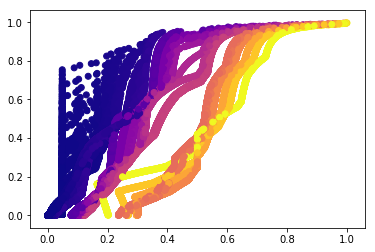

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x=df_2000.loc[:, "NeuralNetwork1"],y=df_2000.loc[:, "myfunc"],c=df_2000.loc[:, "Bank Assets (x2)"],cmap="plasma")

### Neural Network  (softmax regression)
**Keras Model Introduction:**<br>
` STEP1. Define Network`
> - The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. 
- Some 2D layers, such as Dense, support the specification of their input shape via the argument input_dim.
- Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.


` STEP2. Compile Network`
> Before training a model, we need to configure the learning process, which is done via the compile method. It receives three arguments:
- An optimizer - This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. In our case, we use 'adam'
- A loss function - This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. 
- A list of metrics - For any classification problem we will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.

` STEP3. Fit Network`
> Keras models are trained on Numpy arrays of input data and labels. For training a model, we will typically use the fit function.

` STEP4. Evaluate Network`<br>
> - evaluate() will calculate the loss function and the metrics.
- The loss function takes the current output and compares it with the expected/true result. It's a function supposed to be minimized. The less the loss, the closer your results are to the expected. This is the function from which the derivatives will be taken so the backpropagation algorithm can update the weights.

` STEP5. Prediction`

**Softmax function Introduction:**<br>
Softmax function is the popular function to calculate the probabilities of the events. The other mathematical advantages of using the softmax function are the output range.  Softmax function output values are always in the range of (0, 1). The sum of the output values will always equal to the 1. The Softmax is also known as the normalized exponential function.


In [15]:
def NeuralNetwork_1(df_year):
    
    df = copy.deepcopy(df_year)
    # Bring X and y into numpy format
    X_train = df[['Company Liabilities (x1)','Bank Assets (x2)','x1*x2 (x3)']].as_matrix()
    y_bare = df['Connection (y)'].as_matrix()

    # input and output dimensions
    input_dim=X_train.shape[1]
    output_dim = len(set(y_bare)) 
    nb_classes = len(set(y_bare))

    # categorical classification values
    Y_train = np_utils.to_categorical(y_bare, nb_classes)

    ### set up the deep neural net with Keras
    # initiate model
    model = Sequential()
    
    # add weights input_layer--hidden_layer 1
    model.add(Dense(5, input_dim=input_dim, init='lecun_uniform', activation='relu')) 
    # add hidden_layer 2
    model.add(Dense(10, activation='relu'))
    # add hidden_layer 3
    model.add(Dense(55, activation='relu'))

    # output layer
    model.add(Dense(output_dim, activation='relu'))
    model.add(Activation('softmax'))
    
    nb_epoch=60
    batch_size=20
    
    ### compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
    print ("loss value & metrics values = ",model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=False))

    return model
    

In [16]:
def NeuralNetwork_2(df_year):
    df = copy.deepcopy(df_year)
    
    # Bring X and y into numpy format
    X_train = df[['Company Liabilities (x1)','Bank Assets (x2)','x1*x2 (x3)']].as_matrix()
    y_bare = df['Connection (y)'].as_matrix()

    # input and output dimensions
    input_dim=X_train.shape[1]
    output_dim = len(set(y_bare)) 
    nb_classes = len(set(y_bare))

    # categorical classification values
    Y_train = np_utils.to_categorical(y_bare, nb_classes)

    ### set up the deep neural net with Keras
    # initiate model
    model = Sequential()
    
    # add weights input_layer--hidden_layer 1
    model.add(Dense(15, input_dim=input_dim, init='lecun_uniform', activation='relu')) 
    # add hidden_layer 2
    model.add(Dense(20, activation='relu'))
    # add hidden_layer 3
    model.add(Dense(50, activation='relu'))
    # add hidden_layer 4
    model.add(Dense(10, activation='relu'))

    # output layer
    model.add(Dense(output_dim, activation='relu'))
    model.add(Activation('softmax'))
    
    nb_epoch = 80
    batch_size=10
    
    ### compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
    print ("loss value & metrics values = ",model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=False))

    return model

In [17]:
def NeuralNetwork_3(df_year):
    df = copy.deepcopy(df_year)
    
    # Bring X and y into numpy format
    X_train = df[['Company Liabilities (x1)','Bank Assets (x2)','x1*x2 (x3)']].as_matrix()
    y_bare = df['Connection (y)'].as_matrix()

    # input and output dimensions
    input_dim=X_train.shape[1]
    output_dim = len(set(y_bare)) 
    nb_classes = len(set(y_bare))

    # categorical classification values
    Y_train = np_utils.to_categorical(y_bare, nb_classes)
    
    # initiate model
    model = Sequential()
    # add weights input_layer--hidden_layer 1
    model.add(Dense(10, input_dim=input_dim, init='lecun_uniform', activation='relu')) 
    # add hidden_layer 2
    model.add(Dense(5, activation='relu'))
    # add output_layer
    model.add(Dense(output_dim, activation='relu'))
    model.add(Activation('softmax'))
    
    nb_epoch=50
    batch_size=10
    
    ### compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
    print ("loss value & metrics values = ",model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=False))

    return model

In [28]:
def NeuralNetwork_4(df_year):
    df = copy.deepcopy(df_year)
    
    # Bring X and y into numpy format
    X_train = df[['Company Liabilities (x1)','Bank Assets (x2)','x1*x2 (x3)']].as_matrix()
    y_bare = df['Connection (y)'].as_matrix()

    # input and output dimensions
    input_dim=X_train.shape[1]
    output_dim = len(set(y_bare)) 
    nb_classes = len(set(y_bare))

    # categorical classification values
    Y_train = np_utils.to_categorical(y_bare, nb_classes)
    
    # initiate model
    model = Sequential()
    # add weights input_layer--hidden_layer 1
    model.add(Dense(5, input_dim=input_dim, init='lecun_uniform', activation='relu')) 
    # add hidden_layer 2
    model.add(Dense(8, activation='relu'))
    # add hidden_layer 3
    model.add(Dense(6, activation='relu'))
    # add hidden_layer 4
    model.add(Dense(3, activation='relu'))
    # add output_layer
    model.add(Dense(output_dim, activation='relu'))
    model.add(Activation('softmax'))
    
    nb_epoch= 30
    batch_size= 15
    
    ### compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
    print ("loss value & metrics values = ",model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=False))

    return model

In [31]:
def NeuralNetwork_5(df_year):
    df = copy.deepcopy(df_year)
    
    # Bring X and y into numpy format
    X_train = df[['Company Liabilities (x1)','Bank Assets (x2)','x1*x2 (x3)']].as_matrix()
    y_bare = df['Connection (y)'].as_matrix()

    # input and output dimensions
    input_dim=X_train.shape[1]
    output_dim = len(set(y_bare)) 
    nb_classes = len(set(y_bare))

    # categorical classification values
    Y_train = np_utils.to_categorical(y_bare, nb_classes)
    
    # initiate model
    model = Sequential()
    # add weights input_layer--hidden_layer 1
    model.add(Dense(10, input_dim=input_dim, init='lecun_uniform', activation='relu')) 
    # add hidden_layer 2
    model.add(Dense(3, activation='relu'))
    # add hidden_layer 3
    model.add(Dense(30, activation='relu'))
    # add hidden_layer 4
    model.add(Dense(5, activation='relu'))
    # add hidden_layer 5
    model.add(Dense(20, activation='relu'))
    # add output_layer
    model.add(Dense(output_dim, activation='relu'))
    model.add(Activation('softmax'))
    
    nb_epoch= 90
    batch_size= 5
    
    ### compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
    print ("loss value & metrics values = ",model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=False))

    return model

In [34]:
def NeuralNetwork_6(df_year):
    df = copy.deepcopy(df_year)
    
    # Bring X and y into numpy format
    X_train = df[['Company Liabilities (x1)','Bank Assets (x2)','x1*x2 (x3)']].as_matrix()
    y_bare = df['Connection (y)'].as_matrix()

    # input and output dimensions
    input_dim=X_train.shape[1]
    output_dim = len(set(y_bare)) 
    nb_classes = len(set(y_bare))

    # categorical classification values
    Y_train = np_utils.to_categorical(y_bare, nb_classes)
    
    # initiate model
    model = Sequential()
    # add weights input_layer--hidden_layer 1
    model.add(Dense(13, input_dim=input_dim, init='lecun_uniform', activation='relu')) 
    # add hidden_layer 2
    model.add(Dense(25, activation='relu'))
    # add hidden_layer 3
    model.add(Dense(10, activation='relu'))

    # add output_layer
    model.add(Dense(output_dim, activation='relu'))
    model.add(Activation('softmax'))
    
    nb_epoch= 200
    batch_size= 15
    
    ### compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
    print ("loss value & metrics values = ",model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=False))

    return model

In [18]:
NN_model_1 = NeuralNetwork_1(df_2000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, input_dim=3, activation="relu", kernel_initializer="lecun_uniform")`
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


loss value & metrics values =  [0.14777618688863253, 0.9444146072402694]


In [26]:
NN_model_2 = NeuralNetwork_2(df_2000)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=3, activation="relu", kernel_initializer="lecun_uniform")`
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


loss value & metrics values =  [0.14812573313849592, 0.9441020586320884]


In [20]:
NN_model_3 = NeuralNetwork_3(df_2000)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=3, activation="relu", kernel_initializer="lecun_uniform")`
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


loss value & metrics values =  [0.14906321211228432, 0.9392745999143601]


In [29]:
NN_model_4 = NeuralNetwork_4(df_2000)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, input_dim=3, activation="relu", kernel_initializer="lecun_uniform")`
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


loss value & metrics values =  [0.14790538777259657, 0.9443663104238785]


In [32]:
NN_model_5 = NeuralNetwork_5(df_2000)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=3, activation="relu", kernel_initializer="lecun_uniform")`
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


loss value & metrics values =  [0.15022469244626332, 0.9445538391559085]


In [35]:
NN_model_6 = NeuralNetwork_6(df_2000)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(13, input_dim=3, activation="relu", kernel_initializer="lecun_uniform")`
/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


loss value & metrics values =  [0.14833852604334183, 0.9442128773656581]


In [45]:
# Generate Predictions
def NN_predictions_generator(NN_model,df_year,model_number):
    X_train = df_year[['Company Liabilities (x1)','Bank Assets (x2)','x1*x2 (x3)']].as_matrix()
    predictions = NN_model.predict_proba(X_train)
    yHats = [element[1] for element in predictions.tolist()]
    column_name = 'NeuralNetwork'+str(model_number)
    df_year[column_name] = yHats 

In [46]:
NN_predictions_generator(NN_model_1,df_2000,1)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
NN_predictions_generator(NN_model_2,df_2000,2)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
NN_predictions_generator(NN_model_3,df_2000,3)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
NN_predictions_generator(NN_model_4,df_2000,4)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
NN_predictions_generator(NN_model_5,df_2000,5)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
NN_predictions_generator(NN_model_6,df_2000,6)

/Users/yinchiahuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d287d30>,
      dtype=object)

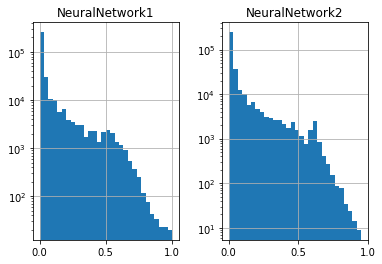

In [93]:
df_2000[['NeuralNetwork1','NeuralNetwork2']].hist(bins=30,log=True)

In [52]:
df_2000

,Company,Bank,Connection (y),Company Liabilities (x1),Bank Assets (x2),x1*x2 (x3),LogiReg,myfunc,NeuralNetwork1,NeuralNetwork2,NeuralNetwork3,NeuralNetwork4,NeuralNetwork5,NeuralNetwork6
0,1,31597,0,0.013559,0.008177,0.000111,0.024735,0.002922,0.008332,0.008305,0.003357,0.007403,0.002304,0.004613
1,1,70001,0,0.013559,5.558135,0.075363,0.781942,0.665775,0.656373,0.634879,0.500000,0.623853,0.621388,0.604521
2,1,70002,1,0.013559,2.187671,0.029663,0.150586,0.439476,0.320899,0.297914,0.352146,0.306472,0.286555,0.278511
3,1,70003,0,0.013559,0.019000,0.000258,0.024969,0.006763,0.016469,0.013065,0.008805,0.013819,0.005612,0.009633
4,1,70004,0,0.013559,4.422931,0.059971,0.565673,0.613175,0.588128,0.600445,0.500000,0.603783,0.661258,0.576887
5,1,70005,0,0.013559,3.926595,0.053241,0.455469,0.584591,0.557008,0.551016,0.500000,0.547936,0.621241,0.527514
6,1,70006,0,0.013559,3.482018,0.047213,0.360030,0.555147,0.528740,0.477979,0.500000,0.496823,0.541110,0.500000
7,1,70007,1,0.013559,4.890041,0.066304,0.663954,0.636702,0.616791,0.614756,0.500000,0.623853,0.684134,0.620641
8,1,70008,0,0.013559,1.889132,0.025615,0.119585,0.403716,0.310440,0.277831,0.291791,0.284363,0.266408,0.269302
9,1,70009,0,0.013559,3.612588,0.048983,0.387284,0.564218,0.537069,0.494161,0.500000,0.511876,0.570264,0.500000


In [54]:
df_2000.to_csv('results.csv')

#### Cross Entropy

In [64]:
CE_Logi = CrossEntropy_caculator(df_2000['LogiReg'].tolist(),df_2000['Connection (y)'].tolist())
CE_myfunc = CrossEntropy_caculator(df_2000['myfunc'].tolist(),df_2000['Connection (y)'].tolist())
CE_NN1 = CrossEntropy_caculator(df_2000['NeuralNetwork1'].tolist(),df_2000['Connection (y)'].tolist())
CE_NN2 = CrossEntropy_caculator(df_2000['NeuralNetwork2'].tolist(),df_2000['Connection (y)'].tolist())
CE_NN3 = CrossEntropy_caculator(df_2000['NeuralNetwork3'].tolist(),df_2000['Connection (y)'].tolist())
CE_NN4 = CrossEntropy_caculator(df_2000['NeuralNetwork4'].tolist(),df_2000['Connection (y)'].tolist())
CE_NN5 = CrossEntropy_caculator(df_2000['NeuralNetwork5'].tolist(),df_2000['Connection (y)'].tolist())
CE_NN6 = CrossEntropy_caculator(df_2000['NeuralNetwork6'].tolist(),df_2000['Connection (y)'].tolist())

In [73]:
print('Cross Entropy')
print('==============================')
print ('LogiReg       :' ,CE_Logi)
print ('myfunc        :' ,CE_myfunc)
print ('NeuralNetwork1:' ,CE_NN1)
print ('NeuralNetwork2:' ,CE_NN2)
print ('NeuralNetwork3:' ,CE_NN3)
print ('NeuralNetwork4:' ,CE_NN4)
print ('NeuralNetwork5:' ,CE_NN5)
print ('NeuralNetwork6:' ,CE_NN6)

Cross Entropy
LogiReg       : 59044.5239555
myfunc        : 58354.76126841183
NeuralNetwork1: 52009.092842017526
NeuralNetwork2: 52132.11394370863
NeuralNetwork3: 52462.05469865061
NeuralNetwork4: 52054.56436471885
NeuralNetwork5: 52870.83210994489
NeuralNetwork6: None


In [75]:
print("LogReg     : ", np.sum(df_2000.loc[:, "LogiReg"]))
print("My function: ", np.sum(df_2000.loc[:, "myfunc"]))
print("Neural net1: ", np.sum(df_2000.loc[:, "NeuralNetwork1"]))
print("Neural net2: ", np.sum(df_2000.loc[:, "NeuralNetwork2"]))
print("Neural net3: ", np.sum(df_2000.loc[:, "NeuralNetwork3"]))
print("Neural net4: ", np.sum(df_2000.loc[:, "NeuralNetwork4"]))
print("Neural net5: ", np.sum(df_2000.loc[:, "NeuralNetwork5"]))
print("Neural net6: ", np.sum(df_2000.loc[:, "NeuralNetwork6"]))

LogReg     :  21372.000000000004
My function:  21372.000216851036
Neural net1:  21641.9776554954
Neural net2:  22266.2343294156
Neural net3:  20317.731610149553
Neural net4:  22220.39771875809
Neural net5:  18464.18850111562
Neural net6:  20306.8918625719


--- 

#### References
http://dataaspirant.com/2017/03/14/multinomial-logistic-regression-model-works-machine-learning/